# DriX: process raw TSG, navigation, meteorological data

Points to be resolved:

- few seconds delay between met station data and inertial station data


In [ ]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
import matplotlib.pyplot as plt
import hvplot.xarray  # noqa
import hvplot.pandas  # noqa

import pynsitu as pin

crs = pin.maps.crs

In [ ]:
# load campaign object
cp = pin.Campaign("cswot23.yaml")

# plotting utils
kwargs_map = dict(extent=cp["lon"] + cp["lat"], bathy=cp["bathy"]["label"])

---

## load data

In [ ]:
# modifie par valerie
def _get_tstamp_dir(d):
    """get time stamp of directory"""
    day = d.split("/")[-1].split("_")[0]
    day = pd.Timestamp(year=int(day[:4]), month=int(day[4:6]), day=int(day[6:8]))
    return day


def _parser(l):
    if len(l) > 0:
        # valerie
        if len(l.split("."))==2:
            return float(l)
        else:
            return ll2dec(l.split(";")[0], l.split(";")[1][:-1], l[-1])
    else:
        return np.NaN


def _emptystring2nan(s):
    if isinstance(s, str) and len(s) == 0:
        return np.NaN
    else:
        return s


def ll2dec(deg, minute, direction):
    if direction == "N" or direction == "E":
        sign = 1
    else:
        sign = -1
    return sign * (float(deg) + float(minute) / 60)


def read_drix_file(file, lon_key, lat_key):
    """load DriX txt data (logged with qinsy)"""

    with open(file, encoding="unicode_escape") as f:
        d = list(f.readlines())
        # replace return carriage from the end of the strings, split each string into a list
        d = [row.replace("\n", "").split(",") for row in d]

    # split in chunks if header changes
    D, C = [], []
    _d = []
    for row in d:
        if row[0] != "Date":
            # fill in data
            _d.append(row)
        else:
            # update column description
            C.append(row)
            if _d:
                D.append(_d)
                _d = []
    D.append(_d)

    DF = []
    for _d, _c in zip(D, C):
        df = pd.DataFrame(_d, columns=_c)
        # convert column 0 and 1 to a datetime
        df["time"] = pd.to_datetime(df["Date"] + " " + df["Time"])
        df.set_index("time", inplace=True)
        # parse coordinates
        df[lat_key + "_tmp"] = df[lat_key].map(_parser)
        df[lon_key + "_tmp"] = df[lon_key].map(_parser)
        # get rid of empty strings
        df = df.applymap(_emptystring2nan)
        # clean up
        df = df.drop(columns=["Date", "Time", lon_key, lat_key])
        df = df.rename(columns={lon_key + "_tmp": lon_key, lat_key + "_tmp": lat_key})
        DF.append(df)

    # convert all columns but index to float
    df = pd.concat(DF)
    for c in df:
        df[c] = df[c].astype(float)

    return df


def read_drix_data(root_dir, lon_key, lat_key, subdirs=False):
    """Read a set of DriX files"""

    if subdirs:
        _dirs = sorted(glob(os.path.join(root_dir, "*")))
        #_dirs = sorted(glob(os.path.join(root_dir, "MiniCT")))

        dirs = pd.DataFrame(
            dict(dirs=_dirs),
            # index=[[_get_tstamp_dir(d) for d in _dirs]], # valerie pas de directory avec la date
        )

        files = []
        for d, s in dirs.iterrows():
            files = files + sorted(glob(os.path.join(s["dirs"], "Daily_Log/*.txt")))
            #files = files + sorted(glob(os.path.join(s["dirs"], "Hourly/*.txt")))
            #files = files + sorted(glob(os.path.join(s["dirs"], "*.txt")))
    else:
        files = sorted(glob(os.path.join(root_dir, "*.txt")))

    # dev
    # files = files[:2]

    # days = {d:d for d in dirs}
    # tstamps = [_get_tstamp(file) for file in files]
    # files = [f for f, t in zip(files, tstamps)
    #         if (t<=cp.end.ceil("d")) and (t>=cp.start.floor("d"))
    #        ]

    df = pd.concat([read_drix_file(f, lon_key, lat_key) for f in files])

    return df

---
## meteo

Data is 1Hz

Questions:

- where is "Station Meteo SOG" coming from, how is it computed?
- ...


In [ ]:
meteo = read_drix_data(
    os.path.join(cp["path_raw"], "StationMeteo_Logs/Daily"),
    "Station Meteo Longitude",
    "Station Meteo Latitude",
)

meteo = meteo.rename(
    columns={
        "Temperature Value": "Temperature",
        "Relative Humidit": "Relative Humidity",
        "Solar Radiation Value": "Solar Radiation",
        "Pressure Value": "Pressure",
        "INS1_Gyro Value": "INS1_Gyro",
        "XTILT Value": "XTILT",
        "YTILT Value": "YTILT",
        "Compass Heading Value": "Compass Heading",
        "ZOrient Value": "ZOrient",
        "U Axis Value": "U Axis",
        "V Axis Value": "V Axis",
        "Volt Value": "Volt",
        "Windstat Value": "Windstat",
        "Status Value": "Status",
        "Station Meteo Longitude": "lon",
        "Station Meteo Latitude": "lat",
    }
)

meteo.columns

In [ ]:
df = meteo

### compare Meteo compas and INS1 Gyro

There seem to be a lag of few seconds between the inertial station and the wind gauge

In [ ]:
df[["Compass Heading", "INS1_Gyro"]].hvplot()

In [ ]:
dphi = (df["Compass Heading"] - df["INS1_Gyro"] + 180) % 360 - 180
dphi.plot.hist(bins=np.arange(-90, 90, 2), grid=True)
print("Mean difference (compass-INS1) = {:.3f} degrees".format(dphi.mean()))

### compare geographical displacements and platform attitudes data (gyro ...)

In [ ]:
df = df.geo.compute_velocities()

Rederiving velocity from coordinates is noisier than what is provided by the variable "Station Meteo SOG

Why ?

In [ ]:
df[["Station Meteo SOG", "velocity"]].hvplot()

One can approximately reconcile speed direction and INS1_Gyro, they are not expected to be equal (course vs heading)

In [ ]:
# direction is positive clockwise from north
df["speed_direction"] = (
    -np.arctan2(-df["velocity_east"], df["velocity_north"]) * 180 / np.pi
) % 360

_df = df.copy()
_df.loc[_df.velocity < 1] = np.NaN
_df[["INS1_Gyro", "speed_direction"]].hvplot()

In [ ]:
_df = df.copy()
_df.loc[_df.velocity < 1] = np.NaN

dphi = ((_df["speed_direction"] - _df["INS1_Gyro"]) + 180) % 360 - 180
dphi.plot.hist(bins=np.arange(-90, 90, 2), grid=True)

print("Mean difference = {:.3f} degrees".format(dphi.mean()))

### compute wind in geographic frame of reference

In [ ]:
# rotates U Axis, V Axis into Earth coordinates first
# phi = "INS1_Gyro"
phi = "Compass Heading"
df["wind_u_relative"] = df["U Axis"] * np.sin(df[phi] / pin.rad2deg) - df[
    "V Axis"
] * np.cos(df[phi] / pin.rad2deg)
df["wind_v_relative"] = df["U Axis"] * np.cos(df[phi] / pin.rad2deg) + df[
    "V Axis"
] * np.sin(df[phi] / pin.rad2deg)

# correct for platform motion
u_met, v_met = "Station Meteo u", "Station Meteo v"
u_met, v_met = "velocity_east", "velocity_north"
df["wind_u_true"] = df["wind_u_relative"] + df[u_met]
df["wind_v_true"] = df["wind_v_relative"] + df[v_met]

In [ ]:
df[["Station Meteo SOG", "U Axis", "wind_u_relative", "wind_u_true"]].hvplot(width=1000)

In [ ]:
df[["V Axis", "wind_v_relative", "wind_v_true"]].hvplot(width=1000)

### store

In [ ]:
_df = df.ts.resample_centered("10s").mean()
_df.to_xarray().to_netcdf(os.path.join(cp["path_processed"], "drix_met_10s.nc"), mode="w")

In [ ]:
_df = df.ts.resample_centered("1T").mean()
_df.to_xarray().to_netcdf(os.path.join(cp["path_processed"], "drix_met_1m.nc"), mode="w")

---
## underway CTDs

In [ ]:
miniCT = read_drix_data(
    os.path.join(cp["path_raw"], "MiniCT_Logs/Daily"), "MiniCT Longitude", "MiniCT Latitude"
)

miniCT = miniCT.rename(
    columns={
        "MiniCT Height": "height",
        "MiniCT Latitude": "lat",
        "MiniCT Longitude": "lon",
        "Conductivité Value": "conductivity",
        "Temperature Value": "temp",
    }
)

miniCT.loc[:,"depth"] = 2.
miniCT.sw.update_eos()

In [ ]:
# sensor corrections (lab measured)
miniCT_eT = pd.DataFrame(
    dict(temperature_ref=[24.8991, 20.0087, 15.1941], 
         temperature_sensor=[24.8809, 19.9911, 15.1791],
         correction=[0.0182, 0.0176, 0.0150]),  # ref - sensor
)
    
miniCT_eC = pd.DataFrame(
    dict(salinity_ref=[24.1661, 24.1696, 24.1701, 35.4521, 35.4567, 35.4554, 35.1430, 35.1492, 35.1521], 
         temperature_bath=[15.1518, 15.1563, 15.1537, 20.4748, 20.4711, 20.4714, 25.4870, 25.4884, 25.4895], 
         conductivity_ref=[30.8529, 30.8602, 30.8589, 48.9579, 48.9597, 48.9584, 53.7752, 53.7852, 53.7902], 
         conductivity_sensor=[30.8421, 30.8479, 30.8466, 48.9375, 48.9346, 48.9364, 53.7481, 53.7537, 53.7595],
         correction=[0.0107, 0.0123, 0.0123, 0.0204, 0.0251, 0.0219, 0.0272, 0.0315, 0.0306]),  # ref - sensor
)

fig, ax = plt.subplots(1,1)
miniCT_eC.plot.scatter(ax=ax,x="conductivity_ref", y="correction", grid=True, label="miniCT", color="k")

In [ ]:
from scipy import interpolate

def correct_temp(temp, sensor):
    """ return correction to temperature measurement"""
    if sensor=="miniCT":
        df = miniCT_eT
    elif sensor=="legato":
        df = legato_eT
    interp = interpolate.interp1d(df["temperature_ref"], 
                                  df["correction"], 
                                  kind="linear", 
                                  bounds_error=False,
                                  fill_value="extrapolate",
                                 )
    correction = interp(temp)
    return correction


_conductivity_intervals = pd.IntervalIndex.from_tuples([(30,31), (48, 49), (53,54)])

def correct_conductivity(conductivity, sensor):
    """ return correction to conductivity measurement"""
    if sensor=="miniCT":
        df = miniCT_eC.copy()
    elif sensor=="legato":
        df = legato_eC.copy()
    df["conductivity"] = pd.cut(df["conductivity_ref"], _conductivity_intervals)
    dfm = df.groupby("conductivity").mean()
    interp = interpolate.interp1d(dfm["conductivity_ref"], 
                                  dfm["correction"], 
                                  kind="linear", 
                                  bounds_error=False,
                                  fill_value="extrapolate",
                                 )
    correction = interp(conductivity)
    return correction


In [ ]:
# compute temperature corrections
miniCT["temp_correction"] = correct_temp(miniCT["temp"], "miniCT")

# compute conductivity corrections
miniCT["conductivity_correction"] = correct_conductivity(miniCT["conductivity"], "miniCT")

# apply corrections
miniCT = miniCT.rename(columns=dict(temp="temp_uncorrected", conductivity="conductivity_uncorrected"))
miniCT["temp"] = miniCT["temp_uncorrected"] + miniCT["temp_correction"]
miniCT["conductivity"] = miniCT["conductivity_uncorrected"] + miniCT["conductivity_correction"]

In [ ]:
uctd = miniCT.ts.resample_centered("1s").mean()

In [ ]:
uctd.to_xarray().to_netcdf(os.path.join(cp["path_processed"], "drix_underway_ctd_1s.nc"), mode="w")
uctd.ts.resample_centered("10s").mean().to_xarray().to_netcdf(
    os.path.join(cp["path_processed"], "drix_underway_ctd_10s.nc"), mode="w"
)

In [ ]:
uctd.head()

### start plotting data

In [ ]:
fig, ax = plt.subplots(1, 1)
uctd["temp"].plot()
ax.grid(which="both")

In [ ]:
fig, ax = plt.subplots(1, 1)
uctd["conductivity"].plot()
ax.grid(which="both")

---
### inertial station

In [ ]:
def load_ins_ascii(file, dt=None):

    # load
    df = pd.read_csv(
        file, delimiter="\t", encoding="iso-8859-1", skiprows=26
    )  # header=27 columns=[]
    df["time"] = pd.to_datetime(df["#date"] + " " + df["time"], errors="coerce")
    df = df.set_index("time").drop(columns=["#date"])

    # subsample
    if dt is not None:
        df = df.ts.resample_centered(dt).median()

    return df

In [ ]:
files = glob(os.path.join(root_dir, "INS/ascii/*.txt"))

dt = "10s"
df = pd.concat([load_ins_ascii(file, dt=dt) for file in files])
df.to_xarray().to_netcdf(os.path.join(cp.pathp, f"drix_ins_{dt}.nc"), mode="w")

---
## turbidity

Data is 2Hz

In [35]:
turb = read_drix_data(
    os.path.join(cp["path_raw"], "Turbidimetre_Logs/Daily"),
    "Turbidimètre Longitude",
    "Turbidimètre Latitude",
)

turb = turb.rename(
    columns={
        "Turbidimètre Height": "height",
        "Tension Value": "tension",
        "Temperature Value": "temperature",
        "V1 Value": "V1",
        "V2 Value": "V2",
        "Turbidimètre Longitude": "lon",
        "Turbidimètre Latitude": "lat",
    }
)

In [36]:
# from G037_OBS-3p_T8749_Calibration-Certificate_20180803.pdf
turb["turbidity_low_range"] = 1.0676e0 * turb["V1"]**2 + 4.3833e1 * turb["V1"] - 9.7576e-2
turb["turbidity_high_range"] = 2.3249e1 * turb["V2"]**2 + 1.6830e2 * turb["V2"] + 2.7114e-1

In [ ]:
(turb["turbidity_low_range"].hvplot() + turb["turbidity_high_range"].hvplot()).cols(1)

In [39]:
df = turb

_df = df.ts.resample_centered("1s").mean()
_df.to_xarray().to_netcdf(os.path.join(cp["path_processed"], "drix_turb_1s.nc"), mode="w")

_df = df.ts.resample_centered("10s").mean()
_df.to_xarray().to_netcdf(os.path.join(cp["path_processed"], "drix_turb_10s.nc"), mode="w")

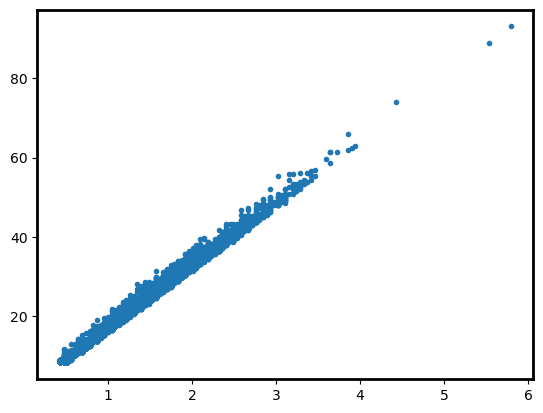

In [40]:
fig, ax = plt.subplots(1, 1)
ax.plot(turb["turbidity_low_range"], turb["turbidity_high_range"], ".")